# test area

In [1]:
import os, sys
import seaborn as sb
import pandas as pd
from datetime import datetime

from pandas_plots import tbl, pls, ven , hlp, pii
# from pandas_plots.hlp import OperatingSystem
from connection_helper import sql
import duckdb as ddb

hlp.show_package_version(["matplotlib_venn"], )
df = sb.load_dataset('taxis')
os.environ['THEME'] = 'dark'

con = ddb.connect()

print(hlp.get_os(hlp.OperatingSystem.MAC))

🐍 3.12.2 | 📦 matplotlib_venn: 0.11.10 | 📦 pandas: 2.2.3 | 📦 numpy: 1.26.4 | 📦 duckdb: 1.1.3 | 📦 pandas-plots: 0.11.20 | 📦 connection_helper: 0.8.11
True


In [2]:
db = con.register('taxis', df).sql("SELECT * FROM taxis")
tbl.descr_db(db, caption="taxis",)

🗄️ taxis	6_433, 14
	("pickup, dropoff, passengers, distance, fare, tip, tolls, total, color, payment, pickup_zone, dropoff_zone, pickup_borough, dropoff_borough")
┌─────────────────────┬─────────────────────┬────────────┬──────────┬────────┬────────┬────────┬────────┬─────────┬─────────────┬───────────────────────┬───────────────────────┬────────────────┬─────────────────┐
│       pickup        │       dropoff       │ passengers │ distance │  fare  │  tip   │ tolls  │ total  │  color  │   payment   │      pickup_zone      │     dropoff_zone      │ pickup_borough │ dropoff_borough │
│    timestamp_ns     │    timestamp_ns     │   int64    │  double  │ double │ double │ double │ double │ varchar │   varchar   │        varchar        │        varchar        │    varchar     │     varchar     │
├─────────────────────┼─────────────────────┼────────────┼──────────┼────────┼────────┼────────┼────────┼─────────┼─────────────┼───────────────────────┼───────────────────────┼────────────────┼────

In [3]:
tbl.print_summary(df)

passengers min: 0 | lower: 0 | q25: 1.0 | median: 1.0 | mean: 1.539 | q75: 2.0 | upper: 3.5 | max: 6 | std: 1.204 | cv: 0.782 | sum: 9_902 | skew: 2.359 | kurto: 4.881
distance min: 0.0 | lower: 0.0 | q25: 0.98 | median: 1.64 | mean: 3.025 | q75: 3.21 | upper: 6.555 | max: 36.7 | std: 3.828 | cv: 1.266 | sum: 19_457.36 | skew: 3.008 | kurto: 11.135
fare min: 1.0 | lower: 1.0 | q25: 6.5 | median: 9.5 | mean: 13.091 | q75: 15.0 | upper: 27.75 | max: 150.0 | std: 11.552 | cv: 0.882 | sum: 84_214.87 | skew: 3.217 | kurto: 17.649
tip min: 0.0 | lower: 0.0 | q25: 0.0 | median: 1.7 | mean: 1.979 | q75: 2.8 | upper: 7.0 | max: 33.2 | std: 2.449 | cv: 1.237 | sum: 12_732.32 | skew: 2.665 | kurto: 12.74
tolls min: 0.0 | lower: 0.0 | q25: 0.0 | median: 0.0 | mean: 0.325 | q75: 0.0 | upper: 0.0 | max: 24.02 | std: 1.415 | cv: 4.351 | sum: 2_092.48 | skew: 5.074 | kurto: 35.442
total min: 1.3 | lower: 1.3 | q25: 10.8 | median: 14.16 | mean: 18.518 | q75: 20.3 | upper: 34.55 | max: 174.82 | std: 13.

In [4]:
# print(f"🟣 uniques: {dict(df.nunique())}")
# print(f"🟣 uniques: {{ {', '.join(f'{col}: {df[col].nunique():_}' for col in df)} }}")
print(f"🟣 uniques: { {col: f'{df[col].nunique():_}' for col in df} }")
print(f"🟣 missings: {dict(df.isna().sum())}")
print(f"🟣 missings: { {col: f'{df[col].isna().sum():_}' for col in df} }")


🟣 uniques: {'pickup': '6_414', 'dropoff': '6_425', 'passengers': '7', 'distance': '1_079', 'fare': '220', 'tip': '489', 'tolls': '16', 'total': '898', 'color': '2', 'payment': '2', 'pickup_zone': '194', 'dropoff_zone': '203', 'pickup_borough': '4', 'dropoff_borough': '5'}
🟣 missings: {'pickup': 0, 'dropoff': 0, 'passengers': 0, 'distance': 0, 'fare': 0, 'tip': 0, 'tolls': 0, 'total': 0, 'color': 0, 'payment': 44, 'pickup_zone': 26, 'dropoff_zone': 45, 'pickup_borough': 26, 'dropoff_borough': 45}
🟣 missings: {'pickup': '0', 'dropoff': '0', 'passengers': '0', 'distance': '0', 'fare': '0', 'tip': '0', 'tolls': '0', 'total': '0', 'color': '0', 'payment': '44', 'pickup_zone': '26', 'dropoff_zone': '45', 'pickup_borough': '26', 'dropoff_borough': '45'}


🔵 *** df: test ***
🟣 shape: (6_433, 14) columns: ['pickup' 'dropoff' 'passengers' 'distance' 'fare' 'tip' 'tolls' 'total'
 'color' 'payment' 'pickup_zone' 'dropoff_zone' 'pickup_borough'
 'dropoff_borough'] 
🟣 duplicates: 0
🟣 uniques: {'pickup': '6_414', 'dropoff': '6_425', 'passengers': '7', 'distance': '1_079', 'fare': '220', 'tip': '489', 'tolls': '16', 'total': '898', 'color': '2', 'payment': '2', 'pickup_zone': '194', 'dropoff_zone': '203', 'pickup_borough': '4', 'dropoff_borough': '5'}
🟣 missings: {'pickup': '0', 'dropoff': '0', 'passengers': '0', 'distance': '0', 'fare': '0', 'tip': '0', 'tolls': '0', 'total': '0', 'color': '0', 'payment': '44', 'pickup_zone': '26', 'dropoff_zone': '45', 'pickup_borough': '26', 'dropoff_borough': '45'}
--- column uniques (all)
🟠 index [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 
27, 28, 29,]
🟠 pickup(6_414|datetime64[ns]) [2019-02-28 23:29:03, 2019-03-01 00:03:29, 2019-03-01 00:08:32, 2019-0

,pickup,dropoff,passengers,distance,fare,tip,tolls,total,color,payment,pickup_zone,dropoff_zone,pickup_borough,dropoff_borough
0,2019-03-23 20:21:09,2019-03-23 20:27:24,1,1.60,7.0,2.15,0.0,12.95,yellow,credit card,Lenox Hill West,UN/Turtle Bay South,Manhattan,Manhattan
1,2019-03-04 16:11:55,2019-03-04 16:19:00,1,0.79,5.0,0.00,0.0,9.30,yellow,cash,Upper West Side South,Upper West Side South,Manhattan,Manhattan
2,2019-03-27 17:53:01,2019-03-27 18:00:25,1,1.37,7.5,2.36,0.0,14.16,yellow,credit card,Alphabet City,West Village,Manhattan,Manhattan


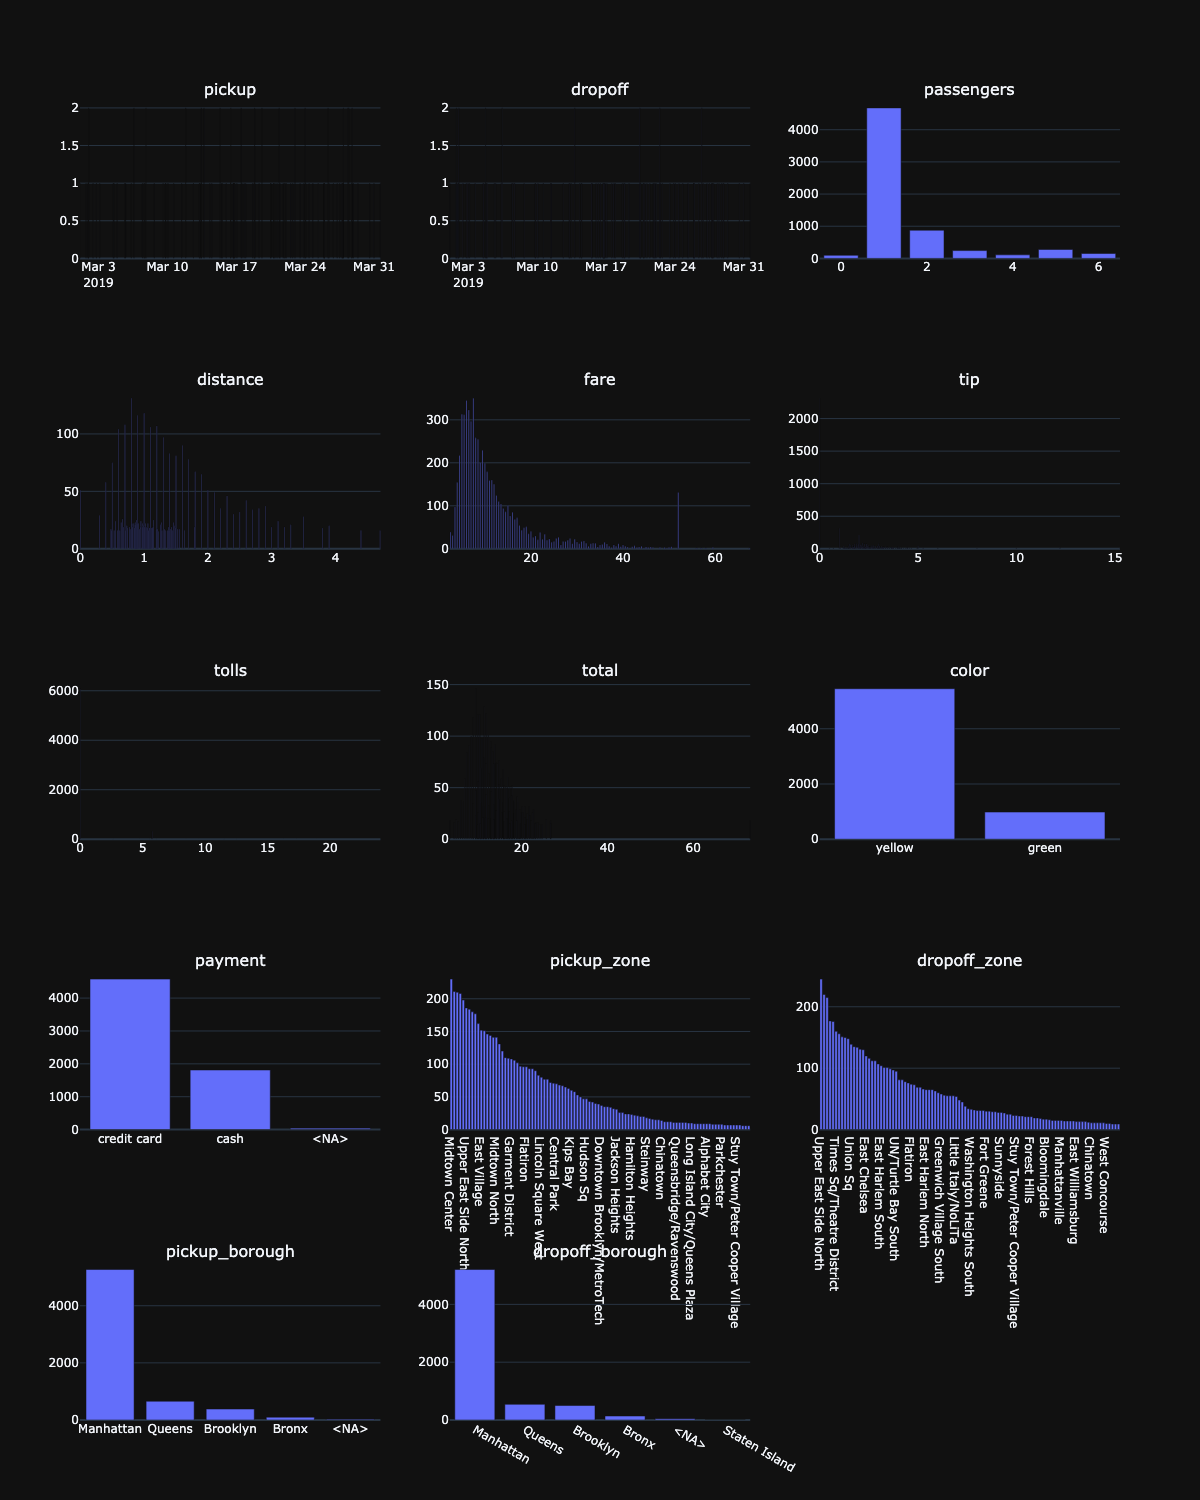

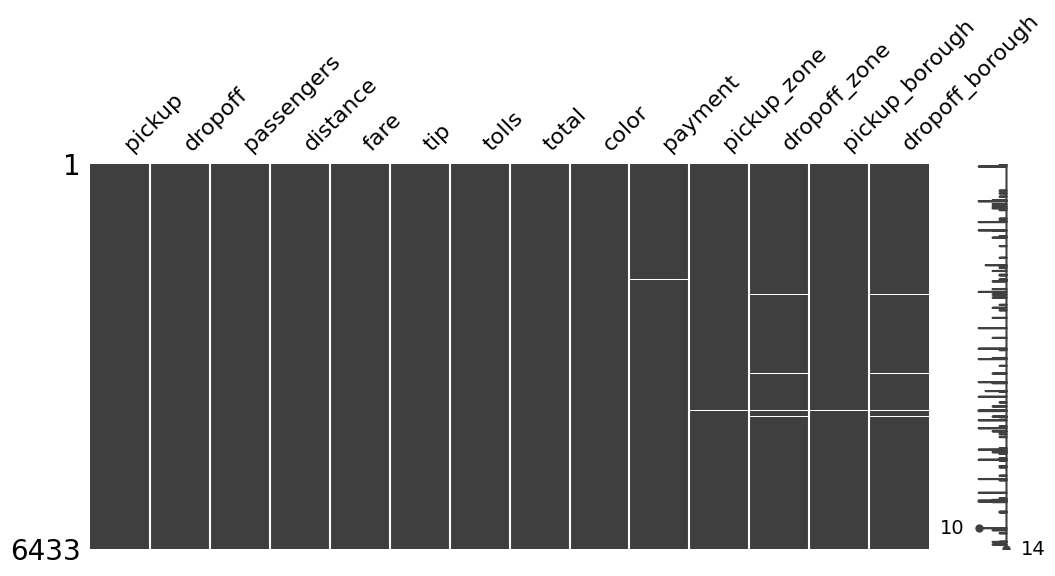

In [ ]:
tbl.describe_df(
    df,
    "test",
    use_plot=True,
    use_columns=True,
    use_missing=True,
)

In [6]:
sys.exit()

SystemExit: 

In [ ]:
# Example data: names and corresponding dates
data = ["Alice", "Bob", "Charlie", "Dr. David", "DrEve lol 23.05.2020", None, ""]
df = pd.DataFrame(data, columns=['Data'])
df['New_Column'] = [10, 20, 30, 40, 50, 60, 70]

# Print the Series
print(df)

_ = pii.remove_pii(df['Data'], logging=True, verbose=True,custom_regex=r"Bob")
df.drop(axis=0, index=_, inplace=False)

In [ ]:
hlp.get_os(OperatingSystem.MAC)

## describe

In [ ]:

tbl.describe_df(df, 'dataframe', top_n_uniques=5, top_n_chars_in_index=5)
# lol=txt.wrap(list(df['passengers'].sort_values().value_counts().index), max_items_in_line=40)
# lol=wrap('kldjfldjfljö', max_items_in_line=40)
# lol=list(df['passengers'].value_counts().sort_index().index)[:3]
# lol
# txt.wrap(lol)

## show num

In [ ]:
_df = df[["passengers", "distance", "fare"]][:5]
tbl.show_num_df(
    _df,
    total_axis="xy",
    total_mode="mean",
    data_bar_axis="xy",
    pct_axis="",
    precision=2,
    total_exclude=False,
    show_as_pct=True,
    # kpi_mode="",
    # kpi_mode="max_min_x",
    # kpi_rag_list=(1,7),
)

In [ ]:
_df=df.pivot_table(index="color", columns="payment", values="fare", aggfunc="sum", dropna=False)
tbl.show_num_df(
    _df,
    total_mode="sum",
    total_axis="y",
    data_bar_axis="",
    pct_axis="xy",
    precision=0,
    heatmap_axis="xy",
    # kpi_mode="max_min_x",
    total_exclude=True,
    # kpi_mode="min_max_xy",
    kpi_mode="rag_abs",
    kpi_rag_list=(100, 1000),
    # swap=True,
)

In [ ]:
sys.exit()

In [ ]:
_df=df[["color", "payment", "fare"]]
tbl.pivot_df(
    _df,
    total_mode="sum",
    data_bar_axis="xy",
    pct_axis="xy",
    precision=0,
    heatmap_axis="",
    kpi_mode="max_min_x"
    # kpi_mode="min_max_xy",
    # kpi_mode="rag_abs",
    # kpi_rag_list=(100, 1000),
)

In [ ]:
_df = df[["distance", "fare", "tip", "tolls"]][:5]
tbl.show_num_df(
    _df,
    data_bar_axis="x",
    pct_axis="xy",
    precision=3,
    total_mode="sum",
)
# _df['distance'].mean()

## venn

ab --> cars1 | cars2 --> len: 7


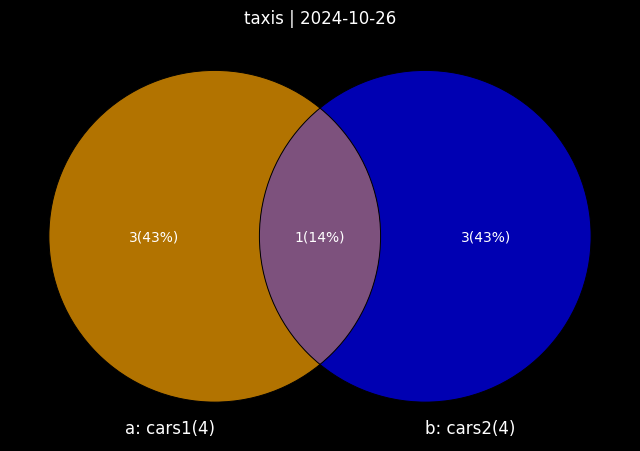

In [ ]:
from pandas_plots import ven

set_a = {'ford','ferrari','mercedes', 'bmw'}
set_b = {'opel','bmw','bentley','audi'}
_df, _details = ven.show_venn2(
    title="taxis",
    a_set=set_a,
    a_label="cars1",
    b_set=set_b,
    b_label="cars2",
    verbose=0,
    size=8,
)

abc --> cars1 | cars2 | cars3 --> len: 11
ab --> cars1 | cars2 --> len: 7
ac --> cars1 | cars3 --> len: 8
bc --> cars2 | cars3 --> len: 9


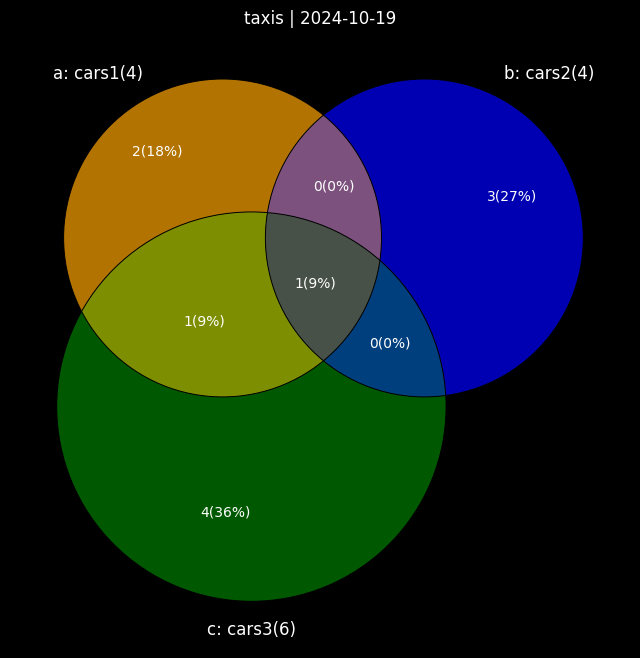

In [ ]:
from pandas_plots import ven

set_a = {'ford','ferrari','mercedes', 'bmw'}
set_b = {'opel','bmw','bentley','audi'}
set_c = {'ferrari','bmw','chrysler','renault','peugeot','fiat'}
_df, _details = ven.show_venn3(
    title="taxis",
    a_set=set_a,
    a_label="cars1",
    b_set=set_b,
    b_label="cars2",
    c_set=set_c,
    c_label="cars3",
    verbose=0,
    size=8,
)

## stacked bars

In [ ]:
# plotly
import plotly_express as px

_fig=px.bar(_df, x=_df.index, y=_df.columns, title="taxis", text_auto=True, orientation="v")
_fig.update_layout(barnorm="percent")

_fig.show()
_df

In [ ]:
from pandas_plots import pls

_df = df
_df['is_green']=_df['color'].apply(lambda x: x=='green')

pls.plot_stacked_bars(
    _df[["is_green", "pickup_zone"]][:15000],
    swap=True,
    orientation="v",
    normalize=False,
    relative=True,
    height=1000,
)

## boxes

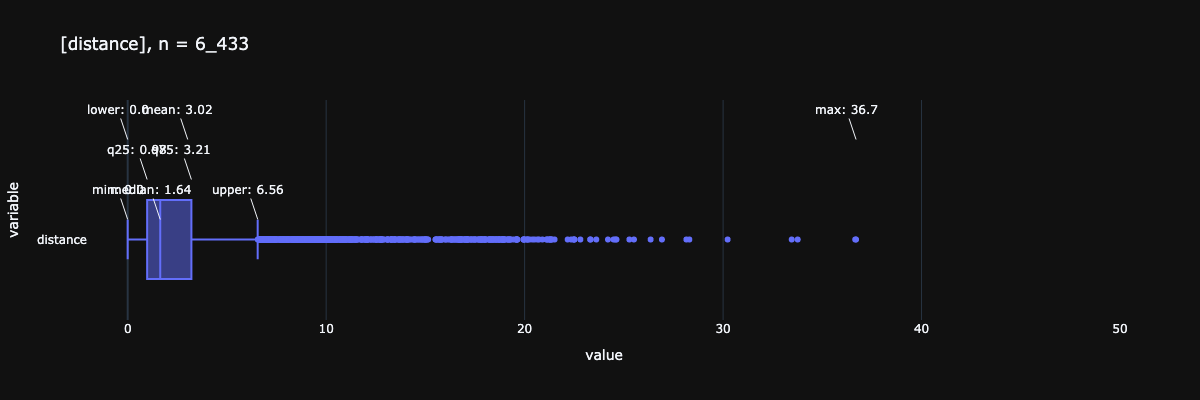

🟠  min: 0.0 | lower: 0.0 | q25: 0.98 | median: 1.64 | mean: 3.025 | q75: 3.21 | upper: 6.555 | max: 36.7 | std: 3.828 | cv: 1.266 | sum: 19_457.36 | skew: 3.008 | kurto: 11.135


In [ ]:
pls.plot_box(
    df.distance,
    height=400,
    violin=False,
    x_min=-2,
    x_max=50,
    # summary = False
)

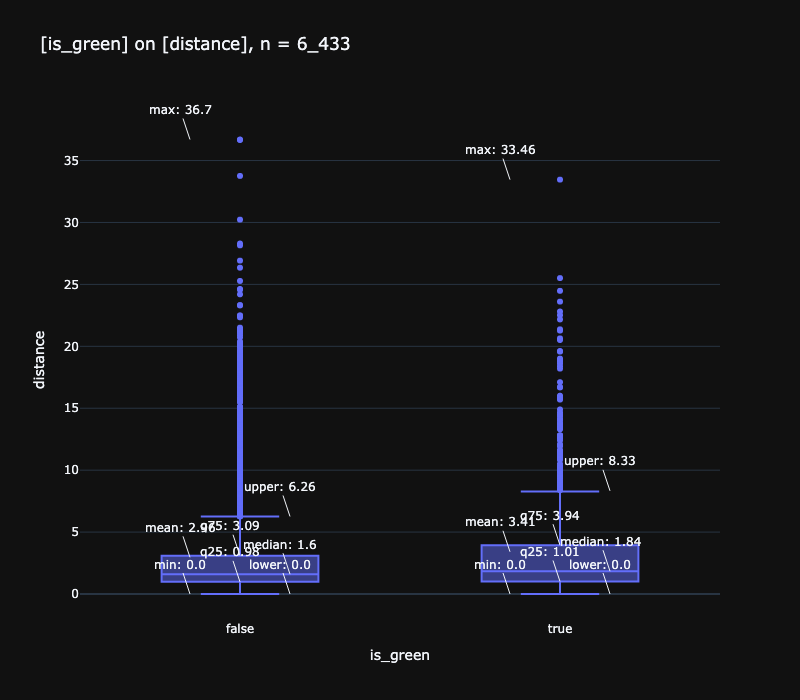

🟠 distance min: 0.0 | lower: 0.0 | q25: 0.98 | median: 1.64 | mean: 3.025 | q75: 3.21 | upper: 6.555 | max: 36.7 | std: 3.828 | cv: 1.266 | sum: 19_457.36 | skew: 3.008 | kurto: 11.135


,color,distance,is_green
0,yellow,1.60,False
1,yellow,0.79,False
2,yellow,1.37,False
3,yellow,7.70,False
4,yellow,2.16,False
...,...,...,...
6428,green,0.75,True
6429,green,18.74,True
6430,green,4.14,True
6431,green,1.12,True


In [ ]:
_df=df[['color','distance']]
_df['is_green']=_df['color'].apply(lambda x: x=='green')
pls.plot_boxes(_df[['is_green','distance']], height=700, )
_df
# pd.api.types.is_bool_dtype(_df['is_green'])

## bars

In [ ]:
import os, sys
import seaborn as sb
import pandas as pd
from importlib.metadata import version
print(f'seaborn: {version("seaborn")}')
from matplotlib import pyplot as plt

from pandas_plots import tbl, pls, ven, hlp
# from pandas_plots.tbl import *
import plotly_express as px

df = sb.load_dataset('taxis')
os.environ['THEME'] = 'light'
df[:3]

In [ ]:
_df=df[["payment","fare"]]
# _df=df["color"]
lol = pls.plot_bars(_df, orientation="v", normalize=True, use_ci=False, precision=0, dropna=True)
# display(lol)

In [ ]:
_df = df["distance"]
# _df#.to_frame()
# _df=df[["fare","distance"]]
pls.plot_histogram(
    _df,
    height=800,
    width=1600,
    precision=0,
    orientation="v",
    histnorm="",
    nbins=0,
    # barmode="overlay",
    renderer="png",
)

In [ ]:
# px.histogram(
#     # df[["fare","passengers"]],
#     df[["fare"]],
#     histnorm="",
#     nbins=0,
#     text_auto=True,
#     marginal="",
#     # barmode="",
#     height=500,
#     width=1200,
# )

In [ ]:
_df = df[["fare", "passengers"]]
# pls.plot_joint(_df, precision=0, size=15, kind="reg", caption="")
pls.plot_joint(_df, precision=0, size=15, kind="hex",)
# pls.plot_joint(_df, precision=0, size=5, kind="kde",)
# pls.plot_joint(_df, precision=0, size=5, kind="hist",)

In [ ]:
_df = df[["fare", "passengers"]]
# sb.set_theme(
#     rc={
#         "axes.facecolor": "lightgray",
#         "figure.facecolor": "cornflowerblue",
#     },
#     palette="tab10"
# )
plt.style.use("dark_background")
# plt.style.use("dark_background")
# fig = 
sb.jointplot(
    x=_df.columns[0],
    y=_df.columns[1],
    data=_df,
    height=5,
    kind="kde",
    ratio=10,
    # marginal_ticks=True,
    # color='k',
    palette="tab10",
    # color="black",
    fill=True,
    cmap="rocket",
    # cmap="bone_r",
    title="lol"
)
# plt.show()

In [ ]:
# sys.exit()

## barcode

In [ ]:
from pandas_plots import hlp
url="https://github.com/robert-koch-institut/Bundesweiter_klinischer_Krebsregisterdatensatz-Datenschema_und_Klassifikationen"
# url="http://google.com"

# hlp.create_barcode_from_url(
#     url=url,
#     output_path=".local/zfkd-repo.png",
#     show_image=True,
# )

## misc

In [ ]:
# df
# from pandas_plots import hlp
hlp.add_datetime_columns(df,"dropoff")
# df

In [ ]:
import os, sys
import seaborn as sb
import pandas as pd
from importlib.metadata import version
print(f'seaborn: {version("seaborn")}')
from pandas_plots import tbl, pls, ven, hlp
# from pandas_plots.tbl import *

df = sb.load_dataset('taxis')
os.environ['THEME'] = 'dark'

In [ ]:
lol="""
The most important themes of the draft referendum are:
1. Improving the use of health data for research and innovation, particularly through the establishment of a National Data Access Point;
2. Enhancing the coordination and networking of different stakeholders involved in health data management;
3. Expanding the scope of the General Data Protection Regulation (GDPR) to cover all areas of healthcare;
4. Providing better access to health data for patients and researchers, including through the development of a new law on health data protection;
5. Facilitating the exchange of health data between different countries and regions, particularly within the European Union (EU);
6. Ensuring that data are used in a way that promotes sustainable development and achieves the United Nations' Sustainable Development Goals (SDGs)."""

In [ ]:
print(
hlp.wrap_text(
    text=lol,
    # max_items_in_line=40,
    use_sep=True,
    use_apo=True,
)
)